## Business Understanding

Since the introduction of the Nintendo Entertainment System in 1985 there has been a proliferation of new and more advanced gaming systems and videogames introduced to the global market. Though many companies likely have methods and tools that would predict the success of new videogames, new tools could help game publishers determine the success of a game based on previous sales. This may reduce the risk of a game that does not give a good return on investment and allow the company to invest thier resources in projects that would have a higher likelihood of success.

## Data Understanding

The [Project Data](https://data.world/julienf/video-games-global-sales-in-volume-1983-2017) contains over 16,500 records of the sales of individual videogames in each major market from 1980 through 2020 including North America, Europe, and Japan ranked by the total global sales for that game.  The data for the games are common to each market and also contian the title, platform, genre, and publisher of each.  Since the data only had a few features to predict on an more features were engineered from the existing data and an API was used o collect data from the Internet Games Database website.  

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import requests
import json
import warnings
import pickle
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import sleep
from io import BytesIO
from datetime import datetime
from igdb.wrapper import IGDBWrapper
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

## Data Preparation 

Once downloaded the sglobal dataframe could be accessed via Pandas using the .read_csv method.  Inspecting the data showed NA_Sales, JP_Sales, EU_Sales, and Other_Sales' total were equal to the Global_Sales column and were dropped to prevent multicollinearity. Rank was dropped as it was a count of the number of videogames in ascending order and added nothing to the features that could have been predicted on.  The Name column was dropped later to prevent difficulties with one hot encoding the data. Finally, the comparitively small number of NaN values meant dropping them would not cause a large loss in data. 

In [2]:
sglobal = pd.read_csv('../Data/vgsalesGlobale2.csv')
sglobal.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [3]:
sglobal.info()

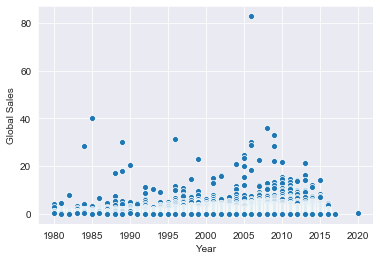

In [4]:
sns.set_style('darkgrid')
sns.scatterplot(sglobal.Year, sglobal.Global_Sales);
plt.ylabel('Global Sales')
plt.show()

#### Dropping columns

In [3]:
# Name column will be dropped later
sglobal.drop(columns=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Rank'], axis=1, inplace=True)
sglobal.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37


#### Dropping NaN values

In [4]:
sglobal.dropna(inplace=True)
sglobal.isna().sum()

Name            0
Platform        0
Year            0
Genre           0
Publisher       0
Global_Sales    0
dtype: int64

#### Creating another feature

Due to the lack of features on which the model could predict, another feature was created to identify if a game has been remade using the Name and Global_Sales columns.  Once the feature was created the Name column was dropped as it was no longer needed.

In [5]:
remake = np.array(sglobal['Name'].duplicated())
remake_df = pd.DataFrame(remake, columns=['Remake'], index=sglobal.index)
remake_df.head()

,Remake
0,False
1,False
2,False
3,False
4,False


In [6]:
sglobal = pd.concat((sglobal,remake_df), axis=1)
sglobal.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74,False
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,False
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,False
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,False
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37,False


In [7]:
sglobal['Remake'] = sglobal['Remake'].astype(int)
sglobal.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74,0
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,0
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,0
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37,0


In [8]:
sglobal_nn = sglobal.drop('Name', axis='columns')
sglobal.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74,0
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,0
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,0
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37,0


## Coding the first model

In [86]:
y = sglobal_nn['Global_Sales']
X = sglobal_nn.drop('Global_Sales', axis=1)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [88]:
# OneHotEncoding X_train and X_test columns

ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(X_train[['Platform', 'Genre', 'Publisher']])

ohe_cats = pd.DataFrame(ohe.transform(X_train[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_train.index)

ohe_cats_test= pd.DataFrame(ohe.transform(X_test[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_test.index)


In [89]:
# Dropping the unnecessary columns
X_train.drop(columns=['Platform', 'Genre', 'Publisher'], axis=1, inplace=True)
X_test.drop(columns=['Platform', 'Genre', 'Publisher'], axis=1, inplace=True)

In [90]:
# Concatenating the one hotted columns
X_train_ohe = pd.concat((X_train, ohe_cats), axis=1)
X_test_ohe = pd.concat((X_test, ohe_cats_test), axis=1)

In [91]:
X_train_ohe.head()

,Year,Remake,x0_2600,x0_3DO,x0_3DS,x0_DC,x0_DS,x0_GB,x0_GBA,x0_GC,x0_GEN,x0_GG,x0_N64,x0_NES,x0_NG,x0_PC,x0_PCFX,x0_PS,x0_PS2,x0_PS3,x0_PS4,x0_PSP,x0_PSV,x0_SAT,x0_SCD,x0_SNES,x0_TG16,x0_WS,x0_Wii,x0_WiiU,x0_X360,x0_XB,x0_XOne,x1_Action,x1_Adventure,x1_Fighting,x1_Misc,x1_Platform,x1_Puzzle,x1_Racing,x1_Role-Playing,x1_Shooter,x1_Simulation,x1_Sports,x1_Strategy,x2_10TACLE Studios,x2_1C Company,x2_20th Century Fox Video Games,x2_2D Boy,x2_3DO,x2_49Games,x2_505 Games,x2_5pb,x2_7G//AMES,x2_989 Studios,x2_AQ Interactive,x2_ASC Games,x2_ASCII Entertainment,x2_ASCII Media Works,x2_ASK,x2_Abylight,x2_Acclaim Entertainment,x2_Accolade,x2_Ackkstudios,x2_Acquire,x2_Activision,x2_Activision Blizzard,x2_Activision Value,x2_Adeline Software,x2_Aerosoft,x2_Agatsuma Entertainment,x2_Agetec,x2_Aksys Games,x2_Alawar Entertainment,x2_Alchemist,x2_Alternative Software,x2_Alvion,x2_American Softworks,x2_Angel Studios,x2_Answer Software,x2_Aqua Plus,x2_Arc System Works,x2_Arena Entertainment,x2_Arika,x2_ArtDink,x2_Aruze Corp,x2_Ascaron Entertainment GmbH,x2_Asgard,x2_Asmik Ace Entertainment,x2_Asmik Corp,x2_Aspyr,x2_Astragon,x2_Asylum Entertainment,x2_Atari,x2_Athena,x2_Atlus,x2_Avalon Interactive,x2_Avanquest,x2_Avanquest Software,x2_Axela,x2_BAM! Entertainment,x2_BMG Interactive Entertainment,x2_BPS,x2_Banpresto,x2_Benesse,x2_Berkeley,x2_Bethesda Softworks,x2_Big Ben Interactive,x2_Big Fish Games,x2_Bigben Interactive,x2_Black Bean Games,x2_Black Label Games,x2_Blast! Entertainment Ltd,x2_Blue Byte,x2_Bohemia Interactive,x2_Bomb,x2_Boost On,x2_Brash Entertainment,x2_Broccoli,x2_BushiRoad,x2_CBS Electronics,x2_CCP,x2_CDV Software Entertainment,x2_CPG Products,x2_Capcom,x2_Cave,x2_ChunSoft,x2_City Interactive,x2_Cloud Imperium Games Corporation,x2_Coconuts Japan,x2_Codemasters,x2_Codemasters Online,x2_CokeM Interactive,x2_Coleco,x2_Comfort,x2_Commseed,x2_Compile,x2_Compile Heart,x2_Conspiracy Entertainment,x2_Core Design Ltd.,x2_Crave Entertainment,x2_Creative Core,x2_Crimson Cow,x2_Crystal Dynamics,x2_Culture Brain,x2_Culture Publishers,x2_CyberFront,x2_Cygames,x2_D3Publisher,x2_DHM Interactive,x2_DSI Games,x2_DTP Entertainment,x2_Daedalic,x2_Daedalic Entertainment,x2_Daito,x2_Data Age,x2_Data Design Interactive,x2_Data East,x2_Datam Polystar,x2_Deep Silver,"x2_Destination Software, Inc",x2_Destineer,x2_Detn8 Games,x2_Devolver Digital,x2_DigiCube,x2_Disney Interactive Studios,x2_Dorart,x2_DreamCatcher Interactive,x2_DreamWorks Interactive,x2_Dusenberry Martin Racing,x2_EA Games,x2_EON Digital Entertainment,x2_ESP,x2_Easy Interactive,x2_Ecole,x2_Edia,x2_Eidos Interactive,x2_Electronic Arts,x2_Elf,x2_Elite,x2_Empire Interactive,x2_Encore,x2_Enix Corporation,x2_Enjoy Gaming ltd.,x2_Enterbrain,x2_Epic Games,x2_Epoch,x2_Ertain,x2_Essential Games,x2_Evolved Games,x2_Excalibur Publishing,x2_Experience Inc.,x2_Falcom Corporation,x2_Fields,x2_Flashpoint Games,x2_Flight-Plan,x2_Focus Home Interactive,x2_Focus Multimedia,x2_Foreign Media Games,x2_Fox Interactive,x2_From Software,x2_FuRyu,x2_FuRyu Corporation,x2_Fuji,x2_FunSoft,x2_Funbox Media,x2_Funcom,x2_Funsta,x2_G.Rev,x2_GN Software,x2_GOA,x2_GSP,x2_GT Interactive,x2_Gaga,x2_Gainax Network Systems,x2_Gakken,x2_Game Arts,x2_Game Factory,x2_Game Life,x2_GameMill Entertainment,x2_GameTek,x2_Gamebridge,x2_Gamecock,x2_Gameloft,x2_Gathering of Developers,x2_General Entertainment,x2_Genki,x2_Ghostlight,x2_Giga,x2_Giza10,x2_Global A Entertainment,x2_Global Star,x2_Gotham Games,x2_Graffiti,x2_Grand Prix Games,x2_Graphsim Entertainment,x2_Gremlin Interactive Ltd,x2_Griffin International,x2_Groove Games,x2_GungHo,x2_Gust,x2_HAL Laboratory,x2_HMH Interactive,x2_Hackberry,x2_Hamster Corporation,x2_Happinet,x2_Harmonix Music Systems,x2_Hasbro Interactive,x2_Headup Games,x2_Hearty Robin,x2_Hect,x2_Hello Games,x2_Her Interactive,x2_Hip Interactive,x2_Home Entertainment Suppliers,x2_Hudson Entertainment,x2_Hudson Soft,x2_Human Entertainment,x2_HuneX,x2_IE Institute,x2_ITT Family Games,x2_Iceberg Interactive,x2_Idea Fact

In [92]:
X_test_ohe.head()

,Year,Remake,x0_2600,x0_3DO,x0_3DS,x0_DC,x0_DS,x0_GB,x0_GBA,x0_GC,x0_GEN,x0_GG,x0_N64,x0_NES,x0_NG,x0_PC,x0_PCFX,x0_PS,x0_PS2,x0_PS3,x0_PS4,x0_PSP,x0_PSV,x0_SAT,x0_SCD,x0_SNES,x0_TG16,x0_WS,x0_Wii,x0_WiiU,x0_X360,x0_XB,x0_XOne,x1_Action,x1_Adventure,x1_Fighting,x1_Misc,x1_Platform,x1_Puzzle,x1_Racing,x1_Role-Playing,x1_Shooter,x1_Simulation,x1_Sports,x1_Strategy,x2_10TACLE Studios,x2_1C Company,x2_20th Century Fox Video Games,x2_2D Boy,x2_3DO,x2_49Games,x2_505 Games,x2_5pb,x2_7G//AMES,x2_989 Studios,x2_AQ Interactive,x2_ASC Games,x2_ASCII Entertainment,x2_ASCII Media Works,x2_ASK,x2_Abylight,x2_Acclaim Entertainment,x2_Accolade,x2_Ackkstudios,x2_Acquire,x2_Activision,x2_Activision Blizzard,x2_Activision Value,x2_Adeline Software,x2_Aerosoft,x2_Agatsuma Entertainment,x2_Agetec,x2_Aksys Games,x2_Alawar Entertainment,x2_Alchemist,x2_Alternative Software,x2_Alvion,x2_American Softworks,x2_Angel Studios,x2_Answer Software,x2_Aqua Plus,x2_Arc System Works,x2_Arena Entertainment,x2_Arika,x2_ArtDink,x2_Aruze Corp,x2_Ascaron Entertainment GmbH,x2_Asgard,x2_Asmik Ace Entertainment,x2_Asmik Corp,x2_Aspyr,x2_Astragon,x2_Asylum Entertainment,x2_Atari,x2_Athena,x2_Atlus,x2_Avalon Interactive,x2_Avanquest,x2_Avanquest Software,x2_Axela,x2_BAM! Entertainment,x2_BMG Interactive Entertainment,x2_BPS,x2_Banpresto,x2_Benesse,x2_Berkeley,x2_Bethesda Softworks,x2_Big Ben Interactive,x2_Big Fish Games,x2_Bigben Interactive,x2_Black Bean Games,x2_Black Label Games,x2_Blast! Entertainment Ltd,x2_Blue Byte,x2_Bohemia Interactive,x2_Bomb,x2_Boost On,x2_Brash Entertainment,x2_Broccoli,x2_BushiRoad,x2_CBS Electronics,x2_CCP,x2_CDV Software Entertainment,x2_CPG Products,x2_Capcom,x2_Cave,x2_ChunSoft,x2_City Interactive,x2_Cloud Imperium Games Corporation,x2_Coconuts Japan,x2_Codemasters,x2_Codemasters Online,x2_CokeM Interactive,x2_Coleco,x2_Comfort,x2_Commseed,x2_Compile,x2_Compile Heart,x2_Conspiracy Entertainment,x2_Core Design Ltd.,x2_Crave Entertainment,x2_Creative Core,x2_Crimson Cow,x2_Crystal Dynamics,x2_Culture Brain,x2_Culture Publishers,x2_CyberFront,x2_Cygames,x2_D3Publisher,x2_DHM Interactive,x2_DSI Games,x2_DTP Entertainment,x2_Daedalic,x2_Daedalic Entertainment,x2_Daito,x2_Data Age,x2_Data Design Interactive,x2_Data East,x2_Datam Polystar,x2_Deep Silver,"x2_Destination Software, Inc",x2_Destineer,x2_Detn8 Games,x2_Devolver Digital,x2_DigiCube,x2_Disney Interactive Studios,x2_Dorart,x2_DreamCatcher Interactive,x2_DreamWorks Interactive,x2_Dusenberry Martin Racing,x2_EA Games,x2_EON Digital Entertainment,x2_ESP,x2_Easy Interactive,x2_Ecole,x2_Edia,x2_Eidos Interactive,x2_Electronic Arts,x2_Elf,x2_Elite,x2_Empire Interactive,x2_Encore,x2_Enix Corporation,x2_Enjoy Gaming ltd.,x2_Enterbrain,x2_Epic Games,x2_Epoch,x2_Ertain,x2_Essential Games,x2_Evolved Games,x2_Excalibur Publishing,x2_Experience Inc.,x2_Falcom Corporation,x2_Fields,x2_Flashpoint Games,x2_Flight-Plan,x2_Focus Home Interactive,x2_Focus Multimedia,x2_Foreign Media Games,x2_Fox Interactive,x2_From Software,x2_FuRyu,x2_FuRyu Corporation,x2_Fuji,x2_FunSoft,x2_Funbox Media,x2_Funcom,x2_Funsta,x2_G.Rev,x2_GN Software,x2_GOA,x2_GSP,x2_GT Interactive,x2_Gaga,x2_Gainax Network Systems,x2_Gakken,x2_Game Arts,x2_Game Factory,x2_Game Life,x2_GameMill Entertainment,x2_GameTek,x2_Gamebridge,x2_Gamecock,x2_Gameloft,x2_Gathering of Developers,x2_General Entertainment,x2_Genki,x2_Ghostlight,x2_Giga,x2_Giza10,x2_Global A Entertainment,x2_Global Star,x2_Gotham Games,x2_Graffiti,x2_Grand Prix Games,x2_Graphsim Entertainment,x2_Gremlin Interactive Ltd,x2_Griffin International,x2_Groove Games,x2_GungHo,x2_Gust,x2_HAL Laboratory,x2_HMH Interactive,x2_Hackberry,x2_Hamster Corporation,x2_Happinet,x2_Harmonix Music Systems,x2_Hasbro Interactive,x2_Headup Games,x2_Hearty Robin,x2_Hect,x2_Hello Games,x2_Her Interactive,x2_Hip Interactive,x2_Home Entertainment Suppliers,x2_Hudson Entertainment,x2_Hudson Soft,x2_Human Entertainment,x2_HuneX,x2_IE Institute,x2_ITT Family Games,x2_Iceberg Interactive,x2_Idea Fact

## First Model

In [93]:
ss = StandardScaler()

X_train_ohe_ss = ss.fit_transform(X_train_ohe)
X_test_ohe_ss = ss.transform(X_test_ohe)

In [94]:
ridge = Ridge(alpha=4, random_state=42)

ridge.fit(X_train_ohe_ss, y_train)
print(ridge.score(X_train_ohe_ss, y_train))
print(mean_absolute_error(y_train, ridge.predict(X_train_ohe_ss)))

0.16721458113644383
0.5099548577393284


In [20]:
cross_val_score(ridge, X_train_ohe_ss, y_train, cv = 3).mean()

0.13629324302860998

In [21]:
print(ridge.score(X_test_ohe_ss, y_test))
print(mean_absolute_error(y_test, ridge.predict(X_test_ohe_ss)))

0.08850084337939568
0.5671314198954861


## Evaluation of First Model

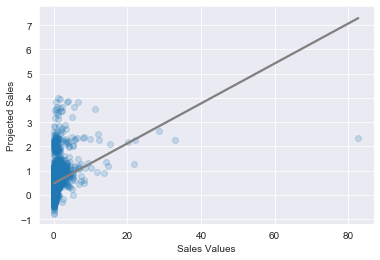

In [96]:
sns.regplot(y_test, ridge.predict(X_test_ohe_ss), ci=False, 
            scatter_kws={'alpha': 0.2}, line_kws={"color": "grey"})
plt.xlabel('Sales Values')
plt.ylabel('Projected Sales');

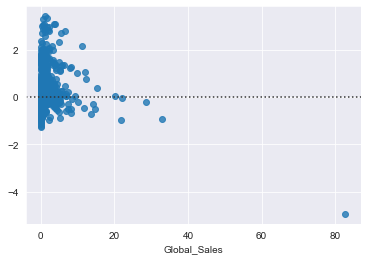

In [95]:
sns.residplot(y_test, ridge.predict(X_test_ohe_ss));

The model is a poor predictor of future data.  Over fitness is demonstrated by the measured difference in the R2 score in the test set versus the training set of close to 50%. In addition, the data is not homoskedastic around the best fit line and the residual plot shows the same.  Both of these show the difficulty the model will have in predicting on an dependent variable. As the lines in each show more easily where the data is better predicted at lower values than at higher values the reliability of the predictions is somewhat untrustworthy.  When the data was chosen it was predicted that the lower number of features would affect the predictions of the data for this reason more data was collected.

## Data Collection

To collect data from [IGDB](pi-docs.igdb.com/#about) create a twitch account.  If the instructions are follwed at the account creation site for Twitch.tv there shouldn't be a major problem.  When filling in the application the OAuth url was set as "http://localhost" to let the system know the data will be run locally and choose analytics tool from the category menu.  Once the application is accepted  a client ID is assigned to you and you can ask for a client secret.  Though this secret is used in the code to collect the data it should not be made public, as such once the code has been run it should be written down or saved to the computer and then deleted from the code.  Once the client ID and client secret have been collected an access token will be needed to collect the data from IGDB.  The request URL is found under the authentification section of the insructions and the client ID and client secret can be filled in to make a successful request.  A wrapper was created to deliver the data in a format comptible with python under wrappers, however, the readme file that shows how to run the data contains an issue that throws an error.  The solution can be found in a discussion entitled 'Main Readme Example Does Not Work' uner the issues tab.  

In [ ]:
!pip install igdb-api-v4 #Installs the wrapper

In [ ]:
# Don't upload to Git!
client_ID = 'ryht2y9jvswue4yv5ddm894h7qvxdn'
client_secret = # Removed for security reasons

r = requests.post(f"https://id.twitch.tv/oauth2/token?client_id={client_ID}&client_secret={client_secret}&grant_type=client_credentials")
access_token = json.loads(r._content)['access_token']
wrapper = IGDBWrapper(client_ID, access_token)

In [ ]:
# converts the information collected with the wrapper into JSON format
def bytes_to_json(byte_array):
    _  = BytesIO(byte_array)
    return json.loads(_.read())

The data collected was for the games in the sglobal dataframe so the names of the games were used to identify which game data should be returned.  This did not mean that the website would have data on all the games requested so a try/except was set up to allow the request to return None if there was no data so that the request would not throw an error if there were a NaN value.  The final issue to consider when working with this API is the rate limit for requests is four per second.  For this reason, a counter was set up to space out the information returned and told the machine to wait if it thought the rate would exceed the limit.

In [98]:
now = datetime.now
window_open=now()
count=0
data=[]
with tqdm(total=len(sglobal)) as pbar:
    for name in sglobal.Name:
        try:
            byte_array = wrapper.api_request(
                    'games',
                    f'fields *; where name = "{name}";'
            )
            game_info = bytes_to_json(byte_array)
            if not game_info:
                game_info=[None]
        except:
            game_info=[None]

        data.append(game_info[0])
        # the rate monitor
        count+=1
        if count % 4 == 0:
            window_close=now()
            difference= window_close-window_open
            if difference.total_seconds() <= 1:
                sleep(1)
            window_open=now()
        pbar.update(1)

100%|██████████| 16291/16291 [1:08:29<00:00,  3.96it/s]


#### Pickling 

Due to the amount of time it takes to retrieve the data, a pickle file was created in order to prevent the need to access the data a second time.

In [ ]:
# Running this cell saves an instance of the collected data
filename = 'Igdb_data'
outfile = open(filename, 'wb')

pickle.dump(data, outfile)
outfile.close()

In [9]:
# Running this cell will import the collected data if there is a problem
infile = open('Igdb_data','rb')
new_data = pickle.load(infile)
infile.close()

## Creating new features

The first order of business for this new data was to remove the values that were collected that had a value of None and then put the data into a dataframe so it could be filtered and organized.  The data was then filtered to collect the features that appeared to be best for the new model to predict on.  The entries in the new dataframe were not conducive to easy translation however, for this reason only certain columns were usable and newrly all had to be translated into a useful set of data.

In [10]:
valid_data = [] 
for val in new_data: 
    if val != None : 
        valid_data.append(val)

In [11]:
pd.set_option('display.max_columns', None)
new_cols = pd.DataFrame(valid_data)
new_cols.drop_duplicates(subset='id', inplace=True)
new_cols['id'].value_counts()

67583     1
78349     1
122249    1
1418      1
11663     1
         ..
2764      1
717       1
4815      1
69164     1
20482     1
Name: id, Length: 7716, dtype: int64

In [10]:
new_cols.head()

In [12]:
cols_toadd = new_cols[['name','total_rating','platforms', 'similar_games', 'collection']]

In [13]:
new_df = sglobal.merge(cols_toadd, left_on='Name', right_on='name')
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake,name,total_rating,platforms,similar_games,collection
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74,0,Wii Sports,75.116193,[5],"[1244, 1352, 2182, 2185, 2186, 2194, 3915, 488...",681.0
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,0,Super Mario Bros.,83.849890,"[5, 18, 24, 37, 41, 51, 130, 307]","[1067, 1068, 1075, 1078, 1079, 2180, 3340, 334...",6118.0
2,Super Mario Bros.,GB,1999.0,Platform,Nintendo,5.07,1,Super Mario Bros.,83.849890,"[5, 18, 24, 37, 41, 51, 130, 307]","[1067, 1068, 1075, 1078, 1079, 2180, 3340, 334...",6118.0
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,0,Mario Kart Wii,75.661862,[5],"[1074, 1077, 2344, 2349, 2350, 3772, 79812, 11...",449.0
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,0,Wii Sports Resort,84.608302,[5],"[534, 660, 1352, 2181, 2185, 2189, 4881, 18238...",681.0


In [14]:
new_df.drop('name', axis=1, inplace=True)

In [15]:
# This function will translate the entries into counts of iterables creating meaningful entries in the dataframe
def list_to_count(record):
    if type(record)==list:
        return len(record)
    else:
        return 0

In [16]:
new_df['platforms'] = new_df['platforms'].apply(list_to_count)

In [17]:
new_df['similar_games'] = new_df['similar_games'].apply(list_to_count)

In [18]:
new_df['collection'] = new_df['collection'].apply(list_to_count)

In [23]:
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake,total_rating,platforms,similar_games,collection
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74,0,75.116193,0,9,0
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,0,83.849890,0,9,0
2,Super Mario Bros.,GB,1999.0,Platform,Nintendo,5.07,1,83.849890,0,9,0
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,0,75.661862,0,9,0
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,0,84.608302,0,9,0


In [19]:
new_df.dropna(inplace=True)

In [20]:
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake,total_rating,platforms,similar_games,collection
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74,0,75.116193,1,9,0
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,0,83.849890,8,9,0
2,Super Mario Bros.,GB,1999.0,Platform,Nintendo,5.07,1,83.849890,8,9,0
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,0,75.661862,1,9,0
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,0,84.608302,1,9,0


## Coding the Final Model

In [21]:
y = new_df['Global_Sales']
X = new_df.drop('Global_Sales', axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [23]:
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(X_train[['Platform', 'Genre', 'Publisher']])

ohe_cats = pd.DataFrame(ohe.transform(X_train[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_train.index)

ohe_cats_test= pd.DataFrame(ohe.transform(X_test[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_test.index)


In [24]:
X_train.drop(columns=['Platform', 'Genre', 'Publisher', 'Name'], axis=1, inplace=True)
X_test.drop(columns=['Platform', 'Genre', 'Publisher','Name'], axis=1, inplace=True)

In [25]:
X_train_ohe = pd.concat((X_train, ohe_cats), axis=1)
X_test_ohe = pd.concat((X_test, ohe_cats_test), axis=1)

In [26]:
X_train_ohe.shape

(6466, 339)

In [27]:
X_test_ohe.head()

,Year,Remake,total_rating,platforms,similar_games,collection,x0_2600,x0_3DO,x0_3DS,x0_DC,x0_DS,x0_GB,x0_GBA,x0_GC,x0_GEN,x0_N64,x0_NES,x0_NG,x0_PC,x0_PS,x0_PS2,x0_PS3,x0_PS4,x0_PSP,x0_PSV,x0_SAT,x0_SNES,x0_WS,x0_Wii,x0_WiiU,x0_X360,x0_XB,x0_XOne,x1_Action,x1_Adventure,x1_Fighting,x1_Misc,x1_Platform,x1_Puzzle,x1_Racing,x1_Role-Playing,x1_Shooter,x1_Simulation,x1_Sports,x1_Strategy,x2_10TACLE Studios,x2_1C Company,x2_2D Boy,x2_3DO,x2_49Games,x2_505 Games,x2_5pb,x2_989 Studios,x2_AQ Interactive,x2_ASCII Entertainment,x2_Acclaim Entertainment,x2_Accolade,x2_Ackkstudios,x2_Acquire,x2_Activision,x2_Activision Blizzard,x2_Activision Value,x2_Agatsuma Entertainment,x2_Aksys Games,x2_Alawar Entertainment,x2_Alternative Software,x2_Altron,x2_Answer Software,x2_Aqua Plus,x2_Arc System Works,x2_Arena Entertainment,x2_Arika,x2_ArtDink,x2_Ascaron Entertainment GmbH,x2_Aspyr,x2_Astragon,x2_Atari,x2_Atlus,x2_Avalon Interactive,x2_Avanquest,x2_Avanquest Software,x2_BAM! Entertainment,x2_BMG Interactive Entertainment,x2_Banpresto,x2_Bethesda Softworks,x2_Big Ben Interactive,x2_Bigben Interactive,x2_Black Bean Games,x2_Blue Byte,x2_Brash Entertainment,x2_CCP,x2_CDV Software Entertainment,x2_CTO SpA,x2_Capcom,x2_Cave,x2_City Interactive,x2_Cloud Imperium Games Corporation,x2_Codemasters,x2_Codemasters Online,x2_Coleco,x2_Compile,x2_Compile Heart,x2_Conspiracy Entertainment,x2_Crave Entertainment,x2_Crimson Cow,x2_Crystal Dynamics,x2_D3Publisher,x2_DHM Interactive,x2_DSI Games,x2_DTP Entertainment,x2_Daedalic,x2_Daedalic Entertainment,x2_Data Design Interactive,x2_Deep Silver,"x2_Destination Software, Inc",x2_Destineer,x2_Devolver Digital,x2_Disney Interactive Studios,x2_DreamCatcher Interactive,x2_Dusenberry Martin Racing,x2_ESP,x2_Eidos Interactive,x2_Electronic Arts,x2_Electronic Arts Victor,x2_Empire Interactive,x2_Encore,x2_Enix Corporation,x2_Enterbrain,x2_Epic Games,x2_Ertain,x2_Essential Games,x2_Evolved Games,x2_Excalibur Publishing,x2_Falcom Corporation,x2_Focus Home Interactive,x2_Fox Interactive,x2_From Software,x2_FuRyu,x2_FuRyu Corporation,x2_Funbox Media,x2_Funcom,x2_Funsta,x2_GOA,x2_GSP,x2_GT Interactive,x2_Game Factory,x2_Gamebridge,x2_Gamecock,x2_Gathering of Developers,x2_Genki,x2_Ghostlight,x2_Global Star,x2_Gotham Games,x2_Graffiti,x2_Gremlin Interactive Ltd,x2_Groove Games,x2_GungHo,x2_Gust,x2_HAL Laboratory,x2_HMH Interactive,x2_Harmonix Music Systems,x2_Hasbro Interactive,x2_Headup Games,x2_Hip Interactive,x2_Hudson Entertainment,x2_Hudson Soft,x2_Iceberg Interactive,x2_Idea Factory,x2_Idea Factory International,x2_Ignition Entertainment,x2_Imagic,x2_Indie Games,x2_Infogrames,x2_Insomniac Games,x2_Interplay,x2_Introversion Software,x2_JVC,x2_Jaleco,x2_JoWood Productions,x2_Kadokawa Shoten,x2_Kalypso Media,x2_Kemco,x2_Koch Media,x2_Kokopeli Digital Studios,x2_Konami Digital Entertainment,x2_LEGO Media,x2_LSP Games,x2_Laguna,x2_Level 5,x2_Lexicon Entertainment,x2_Lighthouse Interactive,x2_Little Orbit,x2_LucasArts,x2_MTV Games,x2_Mad Catz,x2_Majesco Entertainment,x2_Mamba Games,x2_Marvelous Entertainment,x2_Marvelous Interactive,x2_Mastertronic,x2_Mastiff,x2_Mattel Interactive,x2_Maxis,x2_MediaQuest,x2_Metro 3D,x2_Micro Cabin,x2_Microids,x2_Microprose,x2_Microsoft Game Studios,x2_Midas Interactive Entertainment,x2_Midway Games,x2_Milestone S.r.l.,x2_Mindscape,x2_Mojang,x2_Moss,x2_Mumbo Jumbo,x2_Myelin Media,x2_NCSoft,x2_NDA Productions,x2_NEC Interchannel,x2_Namco Bandai Games,x2_Natsume,x2_Navarre Corp,x2_Nihon Falcom Corporation,x2_Nintendo,x2_Nippon Ichi Software,x2_Nitroplus,x2_Nobilis,x2_Nordic Games,x2_NovaLogic,x2_Number None,x2_O-Games,x2_O3 Entertainment,x2_Ocean,x2_Origin Systems,x2_Oxygen Interactive,x2_PQube,x2_Pack In Soft,x2_Palcom,x2_Paradox Interactive,x2_Parker Bros.,x2_Performance Designed Products,x2_Phantom EFX,x2_Pinnacle,x2_Play It,x2_Playlogic Game Factory,x2_Playmore,x2_PopCap Games,x2_PopTop Software,x2_Popcorn Arcade,x2_Psygnosis,x2_Quelle,x2_Quest,x2_RTL,x2_Rage Software,x2_Rain Games,x2_Rebellion,

In [31]:
rfr = RandomForestRegressor(random_state=42, max_depth=30, max_features=50, min_samples_split=20,)

rfr.fit(X_train_ohe, y_train)

print(rfr.score(X_train_ohe, y_train))
print(mean_absolute_error(y_train, rfr.predict(X_train_ohe)))

0.4358496873949559
0.512946512525038


In [33]:
cross_val_score(rfr, X_train_ohe, y_train, cv=3).mean()

0.23405697786075375

In [37]:
print(rfr.score(X_test_ohe, y_test))
print(mean_absolute_error(y_test, rfr.predict(X_test_ohe)))

0.24878873407259827
0.6108316626503277


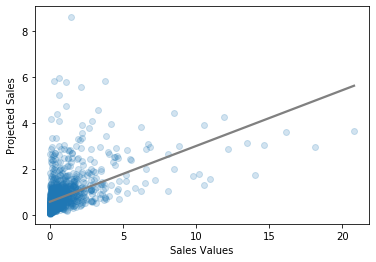

In [40]:
sns.regplot(y_test, rfr.predict(X_test_ohe), ci=False, 
            scatter_kws={'alpha': 0.2}, line_kws={"color": "grey"})
plt.xlabel('Sales Values')
plt.ylabel('Projected Sales')
plt.savefig('FnlMdlRegPlt')

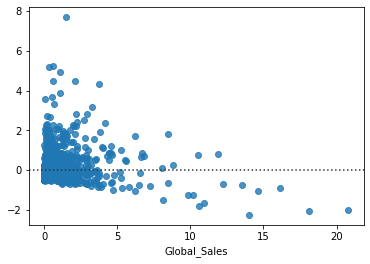

In [41]:
sns.residplot(y_test, rfr.predict(X_test_ohe));
plt.savefig('FnlMdlResiPlt')

## Final Model Evaluation

Compared to the first model the homoskedasticity of this model is far more evident.  Though the data shows a greater distribution about the mean as shown in the residuals graph and the reg plot. The continued inability of the model to predict on datapoints with smaller values rather than larger datapoints speaks to a low accuracy although the demonstrated by an MAE of .6 rather than the .5 of the first model.